# F) DJI Modelling: - (OLS, LSTM) --> (Catboost, XGboost, Naive bayes, and GRU )

### Loading packages

In [1]:
#imports
import yfinance as yf
import numpy as np
import pandas as pd
import os
import exchange_calendars as xcals
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from scipy.stats import zscore
from scipy.stats.mstats import winsorize
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import RFE
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from itertools import product
from bayes_opt import BayesianOptimization

### Loading data

In [2]:
base_path = "C:\\Users\\tgsog\\OneDrive\\Desktop\\DowJones_ML_project\\DataFiles\\E) Feature selected data\\"
ols_path =base_path+"1. OLS data\\"
lstm_path = base_path+"2. LSTM\\"
gru_path= base_path + "3. Gradiant data\\"
nb_path = base_path+"3. Naive bayes data\\"
xg_path = base_path+"3. xgboost data\\"
cat_path = base_path+"3. catboost data\\" 

In [3]:
#MAking bulkloader function
def bulk_load_files(path, name_prefix=None):
    import pandas as pd
    import glob
    import os

    csv_files = glob.glob(os.path.join(path, "*.csv"))

    dataframes = {}
    for file in csv_files:
        key = os.path.basename(file).replace(".csv", "")
        if name_prefix:
            key = f"{name_prefix}_{key}"
        dataframes[key] = pd.read_csv(file)

    return dataframes

In [4]:
ols_dfs = bulk_load_files(ols_path, name_prefix=None)
lstm_dfs = bulk_load_files(lstm_path, name_prefix=None)
gru_dfs = bulk_load_files(gru_path, name_prefix=None)
nb_dfs = bulk_load_files(nb_path, name_prefix=None)
xg_dfs = bulk_load_files(xg_path, name_prefix=None)
cat_dfs = bulk_load_files(cat_path, name_prefix=None)

dfs_list = [ols_dfs,lstm_dfs,gru_dfs,nb_dfs,xg_dfs,cat_dfs]

In [6]:
# Store all your dataset dictionaries in a master dict with model tags
all_dfs = {
    "ols": ols_dfs,
    "lstm": lstm_dfs,
    "gru": gru_dfs,
    "nb": nb_dfs,
    "xg": xg_dfs,
    "cat": cat_dfs
}

# Create a list to keep track of created variable names
all_loaded_variables = []

# Loop through each dictionary and assign variables dynamically
for model_name, model_dfs in all_dfs.items():
    for key, df in model_dfs.items():
        # This assumes keys are already named like "X_train_ols", etc.
        globals()[key] = df
        all_loaded_variables.append(key)


In [7]:
all_loaded_variables

['X_test_ols1',
 'X_test_ols2',
 'X_test_ols3',
 'X_train_ols1',
 'X_train_ols2',
 'X_train_ols3',
 'y_test_ols',
 'y_train_ols',
 'X_test_lstm1',
 'X_test_lstm2',
 'X_train_lstm1',
 'X_train_lstm2',
 'y_test_lstm',
 'y_train_lstm',
 'X_test_gru',
 'X_train_gru',
 'y_test_gru',
 'y_train_gru',
 'X_test_nb',
 'X_train_nb',
 'y_test_nb',
 'y_train_nb',
 'X_test_xg',
 'X_train_xg',
 'y_test_xg',
 'y_train_xg',
 'X_test_cat',
 'X_train_cat',
 'y_test_cat',
 'y_train_cat']

### Loss function calculation 

In [8]:
def calculate_loss_metrics(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100  # Mean Absolute Percentage Error
    r2 = r2_score(y_true, y_pred)
    return mse, rmse, mae, mape, r2

### OLS function

In [9]:
#OLS func
def ols_func(X_train, X_test, y_train):
    import statsmodels.api as sm

    # Add a constant to the independent variables (X)
    X_train_const = sm.add_constant(X_train)
    X_test_const = sm.add_constant(X_test)

    # Fit the OLS model
    model = sm.OLS(y_train, X_train_const).fit()

    # Predict on the test set
    y_pred = model.predict(X_test_const)

    # Optionally print the summary
    return model, model.summary(),y_pred


#### OLS robustness test functions:

In [10]:
def hetero_sed(model):
    import statsmodels.api as sm
    import statsmodels.stats.api as sms
    bp_test = sms.het_breuschpagan(model.resid, model.model.exog)
    bp_labels = ['Lagrange multiplier stat', 'p-value', 'f-value', 'f p-value']
    results = dict(zip(bp_labels, bp_test))
    return results

def shapiro(model):
    from scipy.stats import shapiro, jarque_bera
    jb_stat, jb_pvalue = jarque_bera(model.resid)
    shapiro_stat, shapiro_pvalue = shapiro(model.resid)
    return shapiro_stat, shapiro_pvalue

def vif_rob(X_train):
    from statsmodels.stats.outliers_influence import variance_inflation_factor
    import statsmodels.api as sm
    vif_data = sm.add_constant(X_train)
    vif = pd.DataFrame()
    vif["Variable"] = vif_data.columns
    vif["VIF"] = [variance_inflation_factor(vif_data.values, i) for i in range(vif_data.shape[1])]
    return vif

def drub_watson(model):
    import statsmodels.api as sm
    dw = sm.stats.durbin_watson(model.resid)
    return dw


#Breusch-Pagan p-value < 0.05 ⇒ Heteroscedasticity is present.
#Normality p-values < 0.05 ⇒ Residuals are not normally distributed.
#VIF > 5 or 10 ⇒ Multicollinearity might be an issue.
#Durbin-Watson ~2 ⇒ No autocorrelation; <2 suggests positive autocorr.

### LSTM function

In [ ]:
def lstm_func(X_train, X_test, y_train, y_test):
    import numpy as np
    from tensorflow.keras.models import Sequential
    from tensorflow.keras.layers import LSTM, Dense
    from tensorflow.keras.optimizers import Adam

    # Convert to NumPy arrays (if they are DataFrames)
    X_train = np.array(X_train)
    X_test = np.array(X_test)
    y_train = np.array(y_train)
    y_test = np.array(y_test)

    # Automatically reshape if input is 2D
    if len(X_train.shape) == 2:
        X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
        X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

    # Build the LSTM model
    model = Sequential()
    model.add(LSTM(50, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(Dense(1))

    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

    # Print model summary
    model.summary()

    # Train the model
    history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test), verbose=1)

    # Make predictions
    y_pred = model.predict(X_test)

    return model, y_pred

### Catboost function

In [82]:
def cat_boost_func(X_train, X_test, y_train):
    import pandas as pd
    from catboost import CatBoostClassifier

    # Initialize CatBoost Classifier
    model = CatBoostClassifier(
        iterations=500,
        learning_rate=0.05,
        depth=6,
        loss_function='Logloss',  # for binary classification
        verbose=100
    )

    # Train the model
    model.fit(X_train, y_train)

    # Predict class labels (0 or 1)
    y_pred = pd.DataFrame(model.predict(X_test), columns=['Predicted'])

    # Optional: get predicted probabilities
    # y_proba = pd.DataFrame(model.predict_proba(X_test)[:, 1], columns=['Prob_1'])

    return model, y_pred


### XGboost

In [89]:
def XG_boost_func(X_train, X_test, y_train):
    import pandas as pd
    from xgboost import XGBClassifier

    # Initialize XGBoost Classifier
    model = XGBClassifier(
        n_estimators=500,
        learning_rate=0.05,
        max_depth=6,
        objective='binary:logistic',  # Binary classification objective
        use_label_encoder=False,
        eval_metric='logloss',
        verbosity=1
    )

    # Train the model
    model.fit(X_train, y_train)

    # Predict class labels (0 or 1)
    y_pred = pd.DataFrame(model.predict(X_test), columns=['Predicted'])

    # Optional: Get predicted probabilities
    # y_proba = pd.DataFrame(model.predict_proba(X_test)[:, 1], columns=['Prob_1'])

    return model, y_pred


### GRU

In [94]:
def gru_func(X_train, X_test, y_train, y_test):
    import numpy as np
    import pandas as pd
    from tensorflow.keras.models import Sequential
    from tensorflow.keras.layers import GRU, Dense
    from tensorflow.keras.optimizers import Adam
    from tensorflow.keras.losses import BinaryCrossentropy

    # Ensure data is in NumPy array format
    X_train = np.array(X_train)
    X_test = np.array(X_test)
    y_train = np.array(y_train)
    y_test = np.array(y_test)

    # Reshape to 3D if 2D
    if len(X_train.shape) == 2:
        X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
        X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

    # Build GRU model for binary classification
    gru_model = Sequential()
    gru_model.add(GRU(50, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])))
    gru_model.add(Dense(1, activation='sigmoid'))  # sigmoid for binary output

    # Compile with binary crossentropy
    gru_model.compile(optimizer=Adam(learning_rate=0.001), loss=BinaryCrossentropy(), metrics=['accuracy'])

    # Print model summary
    gru_model.summary()

    # Train the model
    gru_model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test), verbose=1)

    # Predict probabilities
    y_proba = gru_model.predict(X_test)

    # Convert to class predictions (0 or 1)
    y_pred = pd.DataFrame((y_proba > 0.5).astype(int), columns=['Predicted'])

    return gru_model, y_pred



### Naive bayes function

In [74]:
def naive_bayes_func(X_train,X_test,y_train):
    from sklearn.naive_bayes import GaussianNB

    # Initialize the model
    nb_model = GaussianNB()

    # Train the model
    nb_model.fit(X_train, y_train)

    # Predict on test set
    y_pred = pd.DataFrame(nb_model.predict(X_test))

    return nb_model,y_pred



### Confusion matrix plot

In [ ]:


def plot_binary_confusion_matrix(y_true, y_pred, normalize=False):
    import matplotlib.pyplot as plt
    import seaborn as sns
    from sklearn.metrics import confusion_matrix
    import numpy as np
    labels = ['Negative', 'Positive']
    cm = confusion_matrix(y_true, y_pred)
    
    if cm.shape != (2, 2):
        raise ValueError("This function only supports binary classification (2 classes).")

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        fmt = '.2f'
    else:
        fmt = 'd'

    # Create custom annotations
    group_names = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
    counts = [f"{value:.2f}" if normalize else f"{value}" for value in cm.flatten()]
    labels_combined = [f"{name}\n{count}" for name, count in zip(group_names, counts)]
    labels_matrix = np.asarray(labels_combined).reshape(2, 2)

    # Plot heatmap
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=labels_matrix, fmt='', cmap='Blues',
                xticklabels=labels, yticklabels=labels, square=True, cbar=True)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix (Binary Classification)')
    plt.tight_layout()
    plt.show()


## OLS Modells

### OLS 1

In [17]:
ols_model1, model1_sum, y_pred_ols1 = ols_func(X_train_ols1, X_test_ols1, y_train_ols)
ols1_mse, ols1_rsme, ols1_mae,ols1_mape,ols1_r2=calculate_loss_metrics(y_test_ols, y_pred_ols1)
ols1_mse

0.10277678935853554

### OLS 2

In [18]:
ols_model2, model2_sum, y_pred_ols2 = ols_func(X_train_ols2, X_test_ols2, y_train_ols)
ols2_mse, ols2_rsme, ols2_mae,ols2_mape,ols2_r2=calculate_loss_metrics(y_test_ols, y_pred_ols2)
ols2_mse

1.9706768600259656

### OLS 3

In [19]:
ols_model3, model3_sum, y_pred_ols3 = ols_func(X_train_ols3, X_test_ols3, y_train_ols)
ols3_mse, ols3_rsme, ols3_mae,ols3_mape,ols3_r2=calculate_loss_metrics(y_test_ols, y_pred_ols3)
ols3_mse

2.226188587438508

### OLS comparison

In [20]:
ols_comp_df = pd.DataFrame({"mse":[ols1_mse,ols2_mse,ols3_mse],"rmse":[ols1_rsme,ols2_rsme,ols3_rsme], "mae":[ols1_mae,ols2_mae,ols3_mae], "mape":[ols1_mape,ols2_mape,ols3_mape], "r^2":[ols1_r2,ols2_r2,ols3_r2]})

In [21]:
ols_comp_df

,mse,rmse,mae,mape,r^2
0,0.102777,0.320588,0.265811,NaN,0.927625
1,1.970677,1.403808,1.131422,NaN,-0.387747
2,2.226189,1.492042,1.072036,NaN,-0.567678


### OLS robustness

In [22]:
#Heterosced
ols1_model_hetero = hetero_sed(ols_model1)
ols1_pval =round(ols1_model_hetero["p-value"],2)
print(f"Robustness tests:\n1. The p-value, is {ols1_pval}: if it is smaller than 0.05 then there is heteroscedasticity.")

#normality
ols1_score, ols1_pval=shapiro(ols_model1)
print(f"2. Shapiro p-value is {round(ols1_pval,2)}: if the p-value is smaller than 0.05 then there is not a normal distribution.")

#VIF
ols1_vif = vif_rob(X_train_ols1)
num_mult = len(ols1_vif[ols1_vif.VIF>10])
print(f"3. There are about {num_mult} variables in model 1 that is suffering from multicolinearity.")

#drub_watson
ols1_dw = drub_watson(ols_model1)
print(f"4. The drub_watson score is {ols1_dw}: if it is smaller than 2 then it suggest positive autocorrelation.")

Robustness tests:
1. The p-value, is 0.1: if it is smaller than 0.05 then there is heteroscedasticity.
2. Shapiro p-value is 0.42: if the p-value is smaller than 0.05 then there is not a normal distribution.
3. There are about 7 variables in model 1 that is suffering from multicolinearity.
4. The drub_watson score is 1.831449029008882: if it is smaller than 2 then it suggest positive autocorrelation.


## LSTM Models:

### LSTM model 1

In [34]:
lstm_model1, y_pred_lstm1 = lstm_func(X_train_lstm1,X_test_lstm1,y_train_lstm,y_test_lstm)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 50)                34800     
                                                                 
 dense_1 (Dense)             (None, 1)                 51        
                                                                 
Total params: 34,851
Trainable params: 34,851
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
9/9 [==============================] - 1s 52ms/step - loss: 0.2101 - val_loss: 0.1958
Epoch 2/20
9/9 [==============================] - 0s 9ms/step - loss: 0.1689 - val_loss: 0.1661
Epoch 3/20
9/9 [==============================] - 0s 8ms/step - loss: 0.1353 - val_loss: 0.1394
Epoch 4/20
9/9 [==============================] - 0s 9ms/step - loss: 0.1066 - val_loss: 0.1155
Epoch 5/20
9/9 [==============================] - 0s 9ms/step

In [36]:
mse_l1, rmse_l1, mae_l1, mape_l1, r2_l1 = calculate_loss_metrics(y_test_lstm, y_pred_lstm1)

### LSTM model 2

In [37]:
lstm_model2, y_pred_lstm2 = lstm_func(X_train_lstm2,X_test_lstm2,y_train_lstm,y_test_lstm)

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 50)                20200     
                                                                 
 dense_2 (Dense)             (None, 1)                 51        
                                                                 
Total params: 20,251
Trainable params: 20,251
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
9/9 [==============================] - 1s 37ms/step - loss: 0.0950 - val_loss: 0.0258
Epoch 2/20
9/9 [==============================] - 0s 7ms/step - loss: 0.0177 - val_loss: 0.0354
Epoch 3/20
9/9 [==============================] - 0s 8ms/step - loss: 0.0187 - val_loss: 0.0207
Epoch 4/20
9/9 [==============================] - 0s 7ms/step - loss: 0.0145 - val_loss: 0.0214
Epoch 5/20
9/9 [==============================] - 0s 8ms/step

In [38]:
mse_l2, rmse_l2, mae_l2, mape_l2, r2_l2 = calculate_loss_metrics(y_test_lstm, y_pred_lstm2)

In [ ]:
lstm_comp_df = pd.DataFrame({"mse":[mse_l1,mse_l2],"rmse":[rmse_l1,rmse_l2], "mae":[mae_l1,mae_l2], "mape":[mape_l1,mape_l2]})
lstm_comp_df


In [ ]:
print("LSTM model 2 > LSTM model 1")

LSTM model 2 > LSTM model 1


## Run classification models without OLS and LSTM additions

## Classification models

### 1. Catboost ml model

In [83]:
model_cat, y_pred_cat = cat_boost_func(X_train_cat, X_test_cat, y_train_cat)


0:	learn: 0.6258620	total: 34.9ms	remaining: 17.4s
100:	learn: 0.0198192	total: 775ms	remaining: 3.06s
200:	learn: 0.0052214	total: 1.38s	remaining: 2.06s
300:	learn: 0.0029604	total: 2.01s	remaining: 1.33s
400:	learn: 0.0022940	total: 2.71s	remaining: 670ms
499:	learn: 0.0020729	total: 3.42s	remaining: 0us


In [84]:
mse_cat, rmse_cat, mae_cat, mape_cat, r2_cat = calculate_loss_metrics(y_test_cat, y_pred_cat)
print(f"The cat Boost Mean Squared error is {mse_cat}")

The cat Boost Mean Squared error is 0.038461538461538464


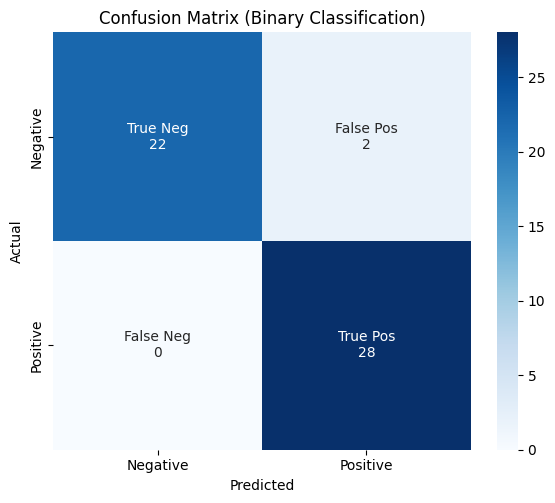

In [86]:
plot_binary_confusion_matrix(y_test_cat, y_pred_cat, normalize=False)

### 2. XGboost ml model

In [90]:
model_xg, y_pred_xg = XG_boost_func(X_train_xg, X_test_xg,y_train_xg)

c:\Users\tgsog\anaconda3\envs\tf_env\lib\site-packages\xgboost\training.py:183: UserWarning: [19:00:20] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


In [91]:
mse_xg, rmse_xg, mae_xg, mape_xg, r2_xg = calculate_loss_metrics(y_test_xg, y_pred_xg)
print(f"The XGboost Mean Squared error is {mse_xg}")

The XGboost Mean Squared error is 0.038461538461538464


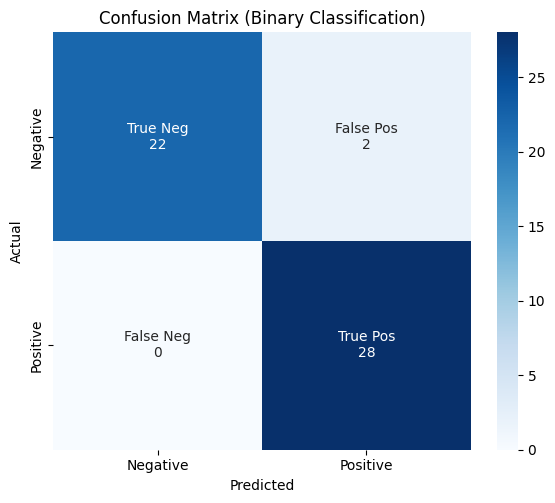

In [92]:
plot_binary_confusion_matrix(y_test_xg, y_pred_xg, normalize=False)

### 3. Gradient recurrent unit ml model

In [95]:
model_gru, y_pred_gru = gru_func(X_train_gru,X_test_gru,y_train_gru,y_test_gru)

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_1 (GRU)                 (None, 50)                15300     
                                                                 
 dense_4 (Dense)             (None, 1)                 51        
                                                                 
Total params: 15,351
Trainable params: 15,351
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
9/9 [==============================] - 2s 52ms/step - loss: 0.6937 - accuracy: 0.5227 - val_loss: 0.6911 - val_accuracy: 0.5385
Epoch 2/20
9/9 [==============================] - 0s 9ms/step - loss: 0.6831 - accuracy: 0.5606 - val_loss: 0.6871 - val_accuracy: 0.5385
Epoch 3/20
9/9 [==============================] - 0s 9ms/step - loss: 0.6807 - accuracy: 0.5606 - val_loss: 0.6846 - val_accuracy: 0.5385
Epoch 4/20
9/9 [===============

In [96]:
mse_gru, rmse_gru, mae_gru, mape_gru, r2_gru = calculate_loss_metrics(y_test_gru, y_pred_gru)
print(f"The Gradient recurrent unit Mean Squared error is {mse_gru}")

The Gradient recurrent unit Mean Squared error is 0.21153846153846154


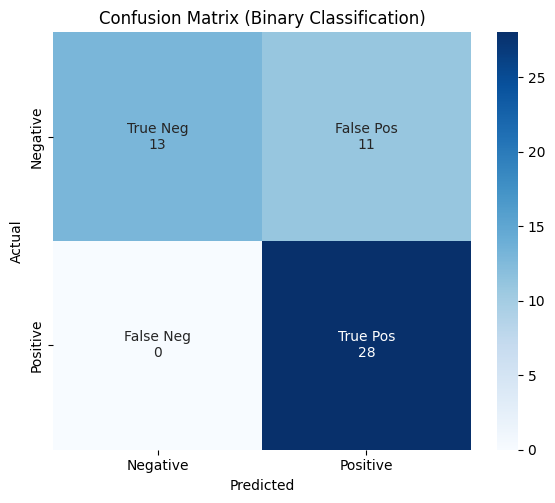

In [97]:
plot_binary_confusion_matrix(y_test_gru, y_pred_gru, normalize=False)

### 4. Naive bayes ml model

In [98]:
model_nb, y_pred_nb = naive_bayes_func(X_train_nb,X_test_nb,y_train_nb)

c:\Users\tgsog\anaconda3\envs\tf_env\lib\site-packages\sklearn\utils\validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [99]:
mse_nb, rmse_nb, mae_nb, mape_nb, r2_nb = calculate_loss_metrics(y_test_nb, y_pred_nb)
print(f"The Gradient recurrent unit Mean Squared error is {mse_nb}")

The Gradient recurrent unit Mean Squared error is 0.4807692307692308


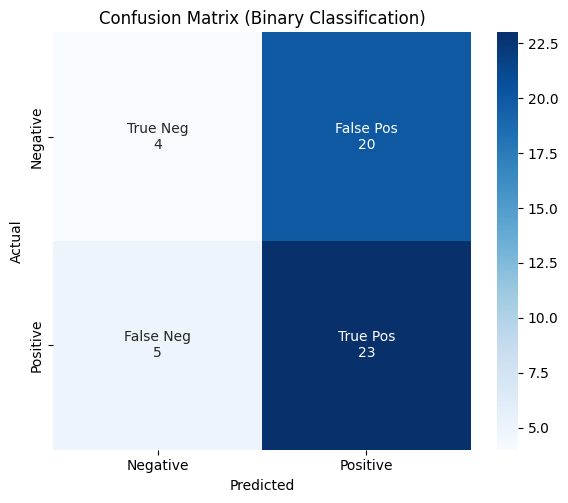

In [100]:
plot_binary_confusion_matrix(y_test_nb, y_pred_nb, normalize=False)

### 5. Compare models

In [ ]:
def classification_metrics_df(y_true, y_pred, average='binary'):
    import pandas as pd
    from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, average=average)
    rec = recall_score(y_true, y_pred, average=average)
    f1 = f1_score(y_true, y_pred, average=average)

    df = pd.DataFrame({
        'Accuracy': [acc],
        'Precision': [prec],
        'Recall': [rec],
        'F1 Score': [f1]
    })

    return df

In [104]:
cat_eval = classification_metrics_df(y_test_cat, y_pred_cat)
xg_eval =classification_metrics_df(y_test_xg, y_pred_xg)
gru_eval =classification_metrics_df(y_test_gru, y_pred_gru)
nb_eval =classification_metrics_df(y_test_nb, y_pred_nb)
eval_df =pd.concat([cat_eval,xg_eval,gru_eval,nb_eval], axis = 0)
eval_df.index = ["CatBoost","XGBoost","GRU","naive bayes"]
eval_df

,Accuracy,Precision,Recall,F1 Score
CatBoost,0.961538,0.933333,1.000000,0.965517
XGBoost,0.961538,0.933333,1.000000,0.965517
GRU,0.788462,0.717949,1.000000,0.835821
naive bayes,0.519231,0.534884,0.821429,0.647887


In [105]:
print(f"The best two models were XGBoost and CatBoost, with a accuracy of 96%")   

The best two models were XGBoost and CatBoost, with a accuracy of 96%
